In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset
from dataclasses import dataclass, field, fields
from typing import List, Dict, Tuple
from torchvision import datasets, transforms
from torchvision.transforms import ToPILImage
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from torch.utils.data import DataLoader
from torch.utils.tensorboard.writer import SummaryWriter
from copy import deepcopy
import os


## Configs

In [2]:

@dataclass
class Configs:
    
    #...general params:
    WORKDIR : str = './'   
    DEVICE : str = 'cuda:0'
    MULTI_GPU : bool = True

    #...data params:
    DATA : str = None
    DATA_TARGET : str = 'cifar10'
    DATA_SOURCE : str = 'noise'
    DIM_INPUT : int = None
    INPUT_SHAPE : Tuple[float] = field(default_factory = lambda : (3, 32, 32))
    
    #...model params:
    MODEL : str = 'Unet32x32'
    NUM_CHANNELS : int = 64
    CHANNEL_MULT : List[float] = field(default_factory = lambda : [1, 2, 2, 2])
    NUM_RES_BLOCKS : int = 2
    NUM_HEADS : int = 4
    DIM_HIDDEN : int = 64 
    ATTENTION_RESOLUTIONS : str = "16"
    DROPOUT : float = 0.1

    #...training params:
    BATCH_SIZE : int = 128
    DATA_SPLIT_FRACS : List[float] = field(default_factory = lambda : [1.0, 0.0, 0.0])  # train / val / test 
    EPOCHS: int = 5
    EARLY_STOPPING : int = None
    MIN_EPOCHS : int = None 
    PRINT_EPOCHS : int = None   
    FIX_SEED : int = None  
    NUM_WORKERS : int = 0
    PIN_MEMORY: bool = False

    #...cfm params:
    DYNAMICS : str = 'CondFlowMatch'
    SIGMA : float = 0.001
    AUGMENTED : bool = False
    T0 : float = 0.0
    T1 : float = 1.0

    #...optimization & scheduler params:
    OPTIMIZER: str = 'Adam'
    LR : float = 1e-4
    WEIGHT_DECAY : float = 0.0
    OPTIMIZER_BETAS : List[float] = field(default_factory = lambda : [0.9, 0.999])
    OPTIMIZER_EPS : float = 1e-8
    OPTIMIZER_AMSGRAD : bool = False
    GRADIENT_CLIP : float = None
    SCHEDULER: str = None
    SCHEDULER_T_MAX: int = None
    SCHEDULER_ETA_MIN: float = None
    SCHEDULER_GAMMA: float = None
    SCHEDULER_STEP_SIZE: int = None

    #...generation pipeline params:
    SAMPLER : str = 'NeuralODE'
    SOLVER : str = 'euler'
    NUM_SAMPLING_STEPS : int = 100
    SENSITIVITY : str = 'adjoint'
    ATOL : float = None
    RTOL : float = None
    NUM_GEN_SAMPLES: int = 10 


    def __post_init__(self):
        self.DATA = self.DATA_SOURCE + '_to_' + self.DATA_TARGET
        self.DIM_INPUT = np.prod(self.INPUT_SHAPE)
        if self.MULTI_GPU: self.DEVICE = 'cuda:0'


## Datamodule

In [3]:
import torch
import numpy as np
from torch.utils.data import DataLoader, Subset
from torch.utils.data import Dataset
from dataclasses import dataclass
from collections import namedtuple

class AbstractDataClass:
    def __init__(self, config: dataclass):
        source: torch.Tensor = None
        target: torch.Tensor = None
        context: torch.Tensor = None
        mask: torch.Tensor = None

    def get_target(self): pass
    def get_source(self): pass
    def get_context(self): pass
    def get_mask(self): pass

class DefineDataSet(Dataset):
    def __init__(self, data: AbstractDataClass):
        self.data = data
        self.databatch = namedtuple('databatch', ['source', 'target', 'context', 'mask'])

    def __getitem__(self, idx):
        return self.databatch(source=self.data.source[idx],
                              target=self.data.target[idx],
                              context=self.data.context[idx],
                              mask=self.data.mask[idx])
    def __len__(self):
        return len(self.data.target)
    
    def __iter__(self):
        for idx in range(len(self)):
            yield self[idx]

class DefineDataloader:
    def __init__(self, 
                 dataclass: AbstractDataClass, 
                 batch_size: int=None, 
                 data_split_frac: tuple=None): 
        self.dataclass = dataclass
        self.config = dataclass.config       
        self.dataset = DefineDataSet(dataclass) 
        self.data_split = self.config.DATA_SPLIT_FRACS if data_split_frac is None else data_split_frac
        self.batch_size = self.config.BATCH_SIZE if batch_size is None else batch_size
        self.dataloader()

    def train_val_test_split(self, shuffle=False):
        assert np.abs(1.0 - sum(self.data_split)) < 1e-3, "Split fractions do not sum to 1!"
        total_size = len(self.dataset)
        train_size = int(total_size * self.data_split[0])
        valid_size = int(total_size * self.data_split[1])

        #...define splitting indices

        idx = torch.randperm(total_size) if shuffle else torch.arange(total_size)
        idx_train = idx[:train_size].tolist()
        idx_valid = idx[train_size : train_size + valid_size].tolist()
        idx_test = idx[train_size + valid_size :].tolist()
        
        #...Create Subset for each split

        train_set = Subset(self.dataset, idx_train)
        valid_set = Subset(self.dataset, idx_valid) if valid_size > 0 else None
        test_set = Subset(self.dataset, idx_test) if self.data_split[2] > 0 else None

        return train_set, valid_set, test_set


    def dataloader(self):

        print("INFO: building dataloaders...")
        print("INFO: train/val/test split ratios: {}/{}/{}".format(self.data_split[0], self.data_split[1], self.data_split[2]))
        
        train, valid, test = self.train_val_test_split(shuffle=True)
        self.train = DataLoader(dataset=train, batch_size=self.batch_size, shuffle=True)
        self.valid = DataLoader(dataset=valid,  batch_size=self.batch_size, shuffle=False) if valid is not None else None
        self.test = DataLoader(dataset=test,  batch_size=self.batch_size, shuffle=True) if test is not None else None

        print('INFO: train size: {}, validation size: {}, testing sizes: {}'.format(len(self.train.dataset),  # type: ignore
                                                                                    len(self.valid.dataset if valid is not None else []),  # type: ignore
                                                                                    len(self.test.dataset if test is not None else []))) # type: ignore


In [4]:

class CIFARDataClass(AbstractDataClass):
    def __init__(self, config: dataclass):

        self.config = config
        
        transform = transforms.Compose([transforms.RandomHorizontalFlip(),
                                        transforms.ToTensor(),
                                        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
                                            )

        cifar = datasets.CIFAR10(root='../../../../data', 
                                train=True, 
                                download=False, 
                                transform=transform)

        if self.config.DATA_TARGET == 'cifar10':
            self.target = cifar.data.transpose((0, 3, 1, 2)).astype(np.float32) / 255.0
            self.target = torch.tensor(self.target)

        if self.config.DATA_SOURCE == 'noise':
            self.source = torch.randn_like(self.target)

        self.context = cifar.targets 
        self.mask = torch.ones_like(self.target)


INFO: building dataloaders...
INFO: train/val/test split ratios: 1.0/0.0/0.0
INFO: train size: 50000, validation size: 0, testing sizes: 0


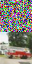

In [5]:
conf = Configs()
cifar = CIFARDataClass(conf)
dataloader = DefineDataloader(cifar)
transform = ToPILImage()

for batch in dataloader.train:
    pair = torch.cat([batch.source[0].squeeze(), batch.target[0].squeeze()], dim=1)
    img = transform(pair)
    break

img

## Train CFM model on CIFAR-10

In [10]:
from DynGenModels.models.utils import Train_Step, Validation_Step, Optimizer, Scheduler, Logger

class DefineModel:
    """
    Trainer for dynamic generative models. e.g. CFM
    
    Attributes:
    - dynamics: The model dynamics to train.
    - dataloader: DataLoader providing training and optionally validation data.
    - config: Configuration dataclass containing training configurations.
    """

    def __init__(self, dynamics, model, dataclass: AbstractDataClass):
        #...config:
        self.config = dataclass.config
        self.dynamics = dynamics
        self.model = model.to(torch.device(self.config.DEVICE))
        self.dataloader = DefineDataloader(dataclass)
        self.workdir = Path(self.config.WORKDIR)
        self.epochs = self.config.EPOCHS
        self.early_stopping = self.config.EPOCHS if self.config.EARLY_STOPPING is None else self.config.EARLY_STOPPING
        self.min_epochs = 0 if self.config.MIN_EPOCHS is None else self.config.MIN_EPOCHS
        self.print_epochs = 1 if self.config.PRINT_EPOCHS is None else self.config.PRINT_EPOCHS
        self.fix_seed = self.config.FIX_SEED

        #...logger & tensorboard:
        os.makedirs(self.workdir/'tensorboard', exist_ok=True)
        self.writer = SummaryWriter(self.workdir/'tensorboard')  
        self.logger = Logger(self.config, self.workdir/'training.log')

    def train(self):
        train = Train_Step()
        valid = Validation_Step()
        optimizer = Optimizer(self.config)(self.model.parameters())
        scheduler = Scheduler(self.config)(optimizer)

        #...logging
        self.logger.logfile.info("Training configurations:")
        for field in fields(self.config): self.logger.logfile.info(f"{field.name}: {getattr(self.config, field.name)}")
        self.logger.logfile_and_console('number of training parameters: {}'.format(sum(p.numel() for p in self.model.parameters())))
        self.logger.logfile_and_console("start training...")

        #...train

        if self.config.MULTI_GPU and torch.cuda.device_count() > 1:
            print("INFO: using ", torch.cuda.device_count(), "GPUs...")
            self.model = torch.nn.DataParallel(self.model)

        for epoch in tqdm(range(self.epochs), desc="epochs"):
            train.update(model=self.model, loss_fn=self.dynamics.loss, dataloader=self.dataloader.train, optimizer=optimizer) 
            valid.update(model=self.model, loss_fn=self.dynamics.loss, dataloader=self.dataloader.valid, seed=self.fix_seed)
            TERMINATE, IMPROVED = valid.checkpoint(min_epochs=self.min_epochs, early_stopping=self.early_stopping)
            scheduler.step() 
            self._log_losses(train, valid, epoch)
            self._save_best_epoch_model(IMPROVED)
            
            if TERMINATE: 
                stop_message = "early stopping triggered! Reached maximum patience at {} epochs".format(epoch)
                self.logger.logfile_and_console(stop_message)
                break
            
        self._save_last_epoch_model()
        self._save_best_epoch_model(not bool(self.dataloader.valid)) # best = last epoch if there is no validation, needed as a placeholder for pipeline
        self.plot_loss(valid_loss=valid.losses, train_loss=train.losses)
        self.logger.close()
        self.writer.close() 
        
    def load(self, path: str=None, model: str=None):
        path = self.workdir if path is None else Path(path)
        if model is None:
            self.best_epoch_model = type(self.model)(self.config)
            self.last_epoch_model = type(self.model)(self.config)
            self.best_epoch_model.load_state_dict(torch.load(path/'best_epoch_model.pth', map_location=(torch.device('cpu') if self.config.DEVICE=='cpu' else None)))
            self.last_epoch_model.load_state_dict(torch.load(path/'last_epoch_model.pth', map_location=(torch.device('cpu') if self.config.DEVICE=='cpu' else None)))
        elif model == 'best':
            self.best_epoch_model = type(self.model)(self.config)
            self.best_epoch_model.load_state_dict(torch.load(path/'best_epoch_model.pth', map_location=(torch.device('cpu') if self.config.DEVICE=='cpu' else None)))
        elif model == 'last':
            self.last_epoch_model = type(self.model)(self.config)
            self.last_epoch_model.load_state_dict(torch.load(path/'last_epoch_model.pth', map_location=(torch.device('cpu') if self.config.DEVICE=='cpu' else None)))
        else: raise ValueError("which_model must be either 'best', 'last', or None")

    def _save_best_epoch_model(self, improved):
        if improved:
            torch.save(self.model.state_dict(), self.workdir/'best_epoch_model.pth')
            self.best_epoch_model = deepcopy(self.model)
        else: pass

    def _save_last_epoch_model(self):
        torch.save(self.model.state_dict(), self.workdir/'last_epoch_model.pth') 
        self.last_epoch_model = deepcopy(self.model)

    def _log_losses(self, train, valid, epoch):
        self.writer.add_scalar('Loss/train', train.loss, epoch)
        self.writer.add_scalar('Loss/valid', valid.loss, epoch)
        message = "\tEpoch: {}, train loss: {}, valid loss: {}  (min valid loss: {})".format(epoch, train.loss, valid.loss, valid.loss_min)
        self.logger.logfile.info(message)
        if epoch % self.print_epochs == 1:            
            self.plot_loss(valid_loss=valid.losses, train_loss=train.losses)
            self.logger.console.info(message)

    def plot_loss(self, valid_loss, train_loss):
        fig, ax = plt.subplots(figsize=(4,3))
        ax.plot(range(len(valid_loss)), np.array(valid_loss), color='r', lw=1, linestyle='-', label='Validation')
        ax.plot(range(len(train_loss)), np.array(train_loss), color='b', lw=1, linestyle='--', label='Training', alpha=0.8)
        ax.set_xlabel("Epochs", fontsize=8)
        ax.set_ylabel("Loss", fontsize=8)
        ax.set_title("Training & Validation Loss Over Epochs", fontsize=6)
        ax.set_yscale('log')
        ax.legend(fontsize=6)
        ax.tick_params(axis='x', labelsize=7)
        ax.tick_params(axis='y', labelsize=7)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5, alpha=0.5)
        fig.tight_layout()
        plt.savefig(self.workdir / 'losses.png')
        plt.close()

def reshape_time_like(t, x):
    if isinstance(t, (float, int)): 
        return t
    else: 
        return t.reshape(-1, *([1] * (x.dim() - 1)))



import torch 
from dataclasses import dataclass

class ConditionalFlowMatching:
	''' Conditional Flow Matching base class
	'''
	def __init__(self, config: dataclass):
		self.sigma_min = config.SIGMA
		self.coupling = config.DYNAMICS

	def define_source_target_coupling(self, batch):
		""" conditional variable z = (x_0, x1) ~ pi(x_0, x_1)
		"""		
		self.x0 = batch.source
		self.x1 = batch.target

	def sample_time(self):
		""" sample time: t ~ U[0,1]
		"""
		t = torch.rand(self.x1.shape[0], device=self.x1.device).type_as(self.x1)
		self.t = self.reshape_time(t, self.x1)

	def sample_gaussian_conditional_path(self):
		""" sample conditional path: x_t ~ p_t(x|x_0, x_1)
		"""
		mean = self.t * self.x1 + (1 - self.t) * self.x0
		std = self.sigma_min
		self.path = mean + std * torch.randn_like(mean)

	def conditional_vector_fields(self):
		""" conditional vector field (drift) u_t(x|x_0,x_1)
		"""
		self.drift = self.x1 - self.x0 

	def loss(self, model, batch):
		""" conditional flow-mathcing MSE loss
		"""
		self.define_source_target_coupling(batch)
		self.sample_time() 
		self.sample_gaussian_conditional_path()
		self.conditional_vector_fields()
		vt = model(x=self.path, t=self.t, mask=None)
		ut = self.drift.to(vt.device)
		loss = torch.square(vt - ut)
		return torch.mean(loss)

	def reshape_time(self, t, x):
		if isinstance(t, (float, int)): return t
		else: return t.reshape(-1, *([1] * (x.dim() - 1)))

In [11]:
from DynGenModels.models.architectures.unet_cifar import UNet32x32 

dynamics = ConditionalFlowMatching(conf)
unet = UNet32x32(conf)


In [12]:
cfm_model = DefineModel(dynamics, unet, cifar)
cfm_model.train()

number of training parameters: 8952067
number of training parameters: 8952067
start training...
start training...


INFO: building dataloaders...
INFO: train/val/test split ratios: 1.0/0.0/0.0
INFO: train size: 50000, validation size: 0, testing sizes: 0
INFO: using  4 GPUs...


/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torch/nn/parallel/data_parallel.py:30: UserWarning: 
    There is an imbalance between your GPUs. You may want to exclude GPU 1 which
    has less than 75% of the memory or cores of GPU 0. You can do so by setting
    the device_ids argument to DataParallel, or by setting the CUDA_VISIBLE_DEVICES
    environment variable.
  warnings.warn(imbalance_warn.format(device_ids[min_pos], device_ids[max_pos]))


epochs:   0%|          | 0/5 [00:00<?, ?it/s]

## image generation

In [14]:
from DynGenModels.pipelines.SamplingPipeline import FlowMatchPipeline

pipeline = FlowMatchPipeline(trained_model=cfm_model, config=conf)
input_source = torch.randn(conf.BATCH_SIZE, *conf.INPUT_SHAPE)
pipeline.generate_samples(input_source)

INFO: neural ODE solver with euler method and steps=100


  0%|          | 0/1 [00:00<?, ?it/s]

/home/df630/.conda/envs/flow_match_env/lib/python3.9/site-packages/torchdyn/numerics/odeint.py:84: UserWarning: Setting tolerances has no effect on fixed-step methods
  warn("Setting tolerances has no effect on fixed-step methods")


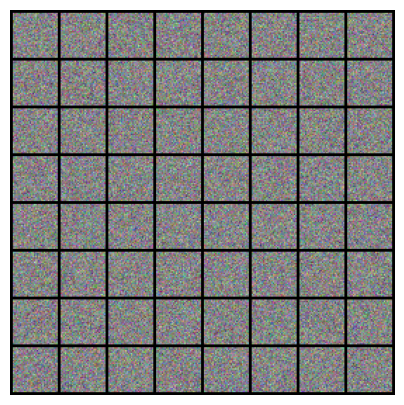

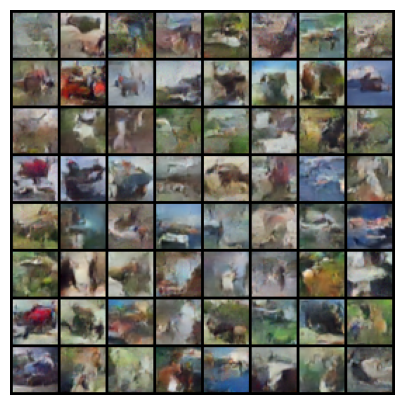

In [15]:
import torch
import torchvision
import matplotlib.pyplot as plt

img_generated = pipeline.trajectories[-1, :] 

grid_img_gen = torchvision.utils.make_grid(img_generated[:64], nrow=8, padding=2, normalize=True)
grid_img_src = torchvision.utils.make_grid(input_source[:64], nrow=8, padding=2, normalize=True)


plt.figure(figsize=(5, 5))
plt.imshow(grid_img_src.permute(1, 2, 0))  # Permute the dimensions to (H, W, C) for plotting
plt.axis('off')  # Turn off the axis
plt.show()

plt.figure(figsize=(5, 5))
plt.imshow(grid_img_gen.permute(1, 2, 0))  # Permute the dimensions to (H, W, C) for plotting
plt.axis('off')  # Turn off the axis
plt.show()


## FID computation

In [ ]:
from cleanfid import fid
score = fid.compute_fid(
    gen=img,
    dataset_name="cifar10",
    batch_size=16,
    dataset_res=128,
    num_gen=128,
    dataset_split="train",
    mode="legacy_tensorflow",
)
print()
print("FID has been computed")
print()
print("FID: ", score)
